In [9]:
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
# Initialize Gemini chat model for reasoning (Agent 1)
reasoning_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Initialize Gemini chat model for image generation (Agent 2)
image_gen_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-preview-image-generation")

In [19]:
# Define the state schema
class State(BaseModel):
    user_input: str = ""
    generated_prompt: str = ""
    image_url: str = ""

In [20]:
# Define system prompts for both agents
reasoning_system_prompt = """Using the principles for effective text-to-image prompting, take the following original prompt and enhance it into a detailed and optimized 'power prompt' for a generative image model. Focus on adding specific visual descriptors and stylistic elements to improve the quality and accuracy of the generated image.


Enhanced Prompt Requirements:
*   Expand on the subject with more specific details (e.g., type of object, material, state).
*   Suggest a specific visual style or artistic medium (e.g., digital painting, photograph, watercolor, pixel art).
*   Describe the desired lighting and atmosphere (e.g., soft light, dramatic shadows, sunny, foggy).
*   Specify the composition or camera angle (e.g., close-up, wide shot, from above).
*   Include details about the background or environment.
*   Mention desired colors or color palette.

The final output should be the single, enhanced prompt text."""

In [21]:
# Agent 1: Reasoning and prompt generation
def agent1(state: State) -> Command[Literal["agent2"]]:
    messages = [
        SystemMessage(content=reasoning_system_prompt),
        HumanMessage(content=state.user_input),
    ]
    response = reasoning_llm.invoke(messages)
    # Assume the response content is the optimized prompt
    return Command(
        goto="agent2",
        update={"generated_prompt": response.content}
    )

In [26]:
# Agent 2: Image generation
def agent2(state: State) -> Command[Literal[END]]:
    messages = [
        HumanMessage(content=state.generated_prompt),
    ]
    response = image_gen_llm.invoke(messages, generation_config=dict(response_modalities=["TEXT", "IMAGE"]))
    # Assume the response content contains the image URL or description
    return Command(
        goto=END,
        update={"image_url": response}
    )

In [27]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node(agent1)
builder.add_node(agent2)
builder.add_edge(START, "agent1")


graph = builder.compile()

In [58]:
user_input = """
A diagram showing the eight phases of the moon with labels as it revolves around Earth. It also indicates the direction of the sunlight.
"""

In [59]:
# Example usage
initial_state = State(user_input=user_input)
result = graph.invoke(initial_state)

In [ ]:
response = result["image_url"]
base64_image = response.content[0]["image_url"]["url"].split(",")[-1]
print(base64_image)

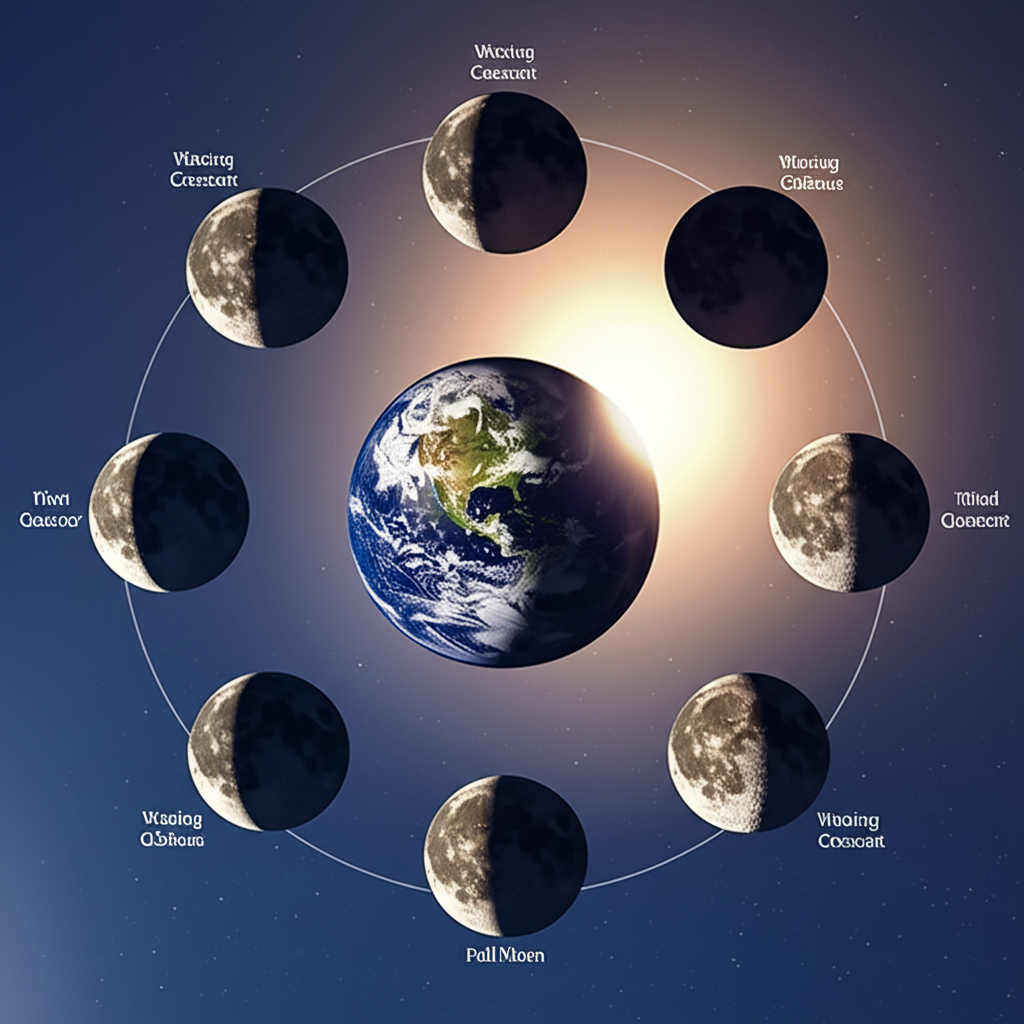

In [64]:
# Decode and display the image
import base64
from IPython.display import Image, display

image_data = base64.b64decode(base64_image)
display(Image(data=image_data, width=800))